In [ ]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import parser_arguments
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
from math import ceil
from numpy import savetxt

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

# Set defaults

In [3]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_Pair_!1"]
chip_fignames = ["ETROC 2.01 EPIR Pair 11"]
# chip_names = ["ET2_EPIR_Pair4"]
# chip_fignames = ["EPIR Pair 4"]
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: /dev/ttyACM0'
port = "/dev/ttyACM2"
# I2C addresses for the pixel block and WS
chip_addresses = [0x60]
# chip_addresses = [0x63]
ws_addresses = [None, None, None, None]

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

full_col_list, full_row_list = np.meshgrid(np.arange(16),np.arange(16))
full_scan_list = list(zip(full_row_list.flatten(),full_col_list.flatten()))

In [4]:
col_list = [2, 4, 8, 2, 4, 8, 2, 4, 8]
row_list = [2, 2, 2, 4, 4, 4, 8, 8, 8]

scan_list = list(zip(row_list, col_list))

scan_list

[(2, 2), (2, 4), (2, 8), (4, 2), (4, 4), (4, 8), (8, 2), (8, 4), (8, 8)]

# Make i2c_connection class object

In [5]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,ws_addresses,chip_names,[("1","1"),("1","1"),("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [44]:
# (WS Prep Pixel and Peri) - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00001100')
i2c_conn.set_power_mode_scan_list(chip_addresses[0], full_scan_list, 'high')
i2c_conn.config_chips('00010000')
# i2c_conn.config_chips('00001111') # disable and more fun things
# i2c_conn.config_chips('00000100') # set basic peripherals
# i2c_conn.config_chips('00010000') # calibrate only
# i2c_conn.config_chips('00000001') # pixel ID check (I2C check)
# i2c_conn.config_chips('10000000') # ws init
# i2c_conn.disable_all_pixels(chip_address=chip_addresses[1])

Peripherals set for chip: 0x60
Disabled pixels for chip: 0x60


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.57s/it]

Auto calibration finished for chip: 0x60


In [24]:
offset = 15
for idx in range(len(chip_addresses)):
    address = chip_addresses[idx]
    i2c_conn.set_chip_offsets(address, chip_names[idx], offset, pixel_list=scan_list, verbose=True)

Offset set to 0xf (DAC from 411 to 411) for pixel (2,2) (BL=396.0) for chip: 0x60
Offset set to 0xf (DAC from 415 to 415) for pixel (2,4) (BL=400.0) for chip: 0x60
Offset set to 0xf (DAC from 410 to 410) for pixel (2,8) (BL=395.0) for chip: 0x60
Offset set to 0xf (DAC from 420 to 420) for pixel (4,2) (BL=405.0) for chip: 0x60
Offset set to 0xf (DAC from 425 to 425) for pixel (4,4) (BL=410.0) for chip: 0x60
Offset set to 0xf (DAC from 431 to 431) for pixel (4,8) (BL=416.0) for chip: 0x60
Offset set to 0xf (DAC from 431 to 431) for pixel (8,2) (BL=416.0) for chip: 0x60
Offset set to 0xf (DAC from 421 to 421) for pixel (8,4) (BL=406.0) for chip: 0x60
Offset set to 0xf (DAC from 430 to 430) for pixel (8,8) (BL=415.0) for chip: 0x60
Offset set to 0xf for chip: 0x60


In [ ]:
chip: i2c_gui.chips.ETROC2_Chip = i2c_conn.get_chip_i2c_connection(chip_addresses[0])

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
broadcast_handle,_,_ = chip.get_indexer("broadcast")

QInjEn_handle = chip.get_indexed_var("ETROC", "Pixel Config", "QInjEn")

row_indexer_handle.set(15)
column_indexer_handle.set(15)

In [ ]:
chip.read_all_block('ETROC2', 'Pixel Config')

broadcast_handle.set(True)
chip.write_all_block("ETROC2", "Pixel Config")

In [25]:
i2c_conn.enable_select_pixels_in_chips(scan_list, verbose = False)

100%|██████████| 9/9 [00:01<00:00,  6.28it/s]


In [48]:
i2c_conn.config_chips('00010000')

Calibrating row:  69%|██████▉   | 11/16 [01:06<00:30,  6.05s/it]


UsbIssError: Expected 1 bytes, but 0 received

In [27]:
i2c_conn.config_chips('00001000')

Disabled pixels for chip: 0x60


In [18]:
#i2c_conn.config_chips('00010000')
#i2c_conn.enable_select_pixels_in_chips(scan_list, verbose = False)
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        #i2c_conn.pixel_decoded_register_write("QSel", format(0x1f, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '1', chip)
        #i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

Operating on chip 0x60 Pixel (2,2)
Operating on chip 0x60 Pixel (2,4)
Operating on chip 0x60 Pixel (2,8)
Operating on chip 0x60 Pixel (4,2)
Operating on chip 0x60 Pixel (4,4)
Operating on chip 0x60 Pixel (4,8)
Operating on chip 0x60 Pixel (8,2)
Operating on chip 0x60 Pixel (8,4)
Operating on chip 0x60 Pixel (8,8)


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [7]:
def make_baselines(do_config = True):
    if do_config:
        i2c_conn.config_chips('00100111')

    histdir = Path('/run/media/daq/T7/ETROC-History-DESY')
    histdir.mkdir(exist_ok=True)
    histfile = histdir / 'BaselineHistory.sqlite'

    # from mpl_toolkits.axes_grid1 import make_axes_locatable
    for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_fignames):
        BL_map_THCal,NW_map_THCal,BL_df,_ = i2c_conn.get_auto_cal_maps(chip_address)
        fig = plt.figure(dpi=200, figsize=(20,10))
        gs = fig.add_gridspec(1,2)

        ax0 = fig.add_subplot(gs[0,0])
        ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
        img0 = ax0.imshow(BL_map_THCal, interpolation='none')
        ax0.set_aspect("equal")
        ax0.invert_xaxis()
        ax0.invert_yaxis()
        plt.xticks(range(16), range(16), rotation="vertical")
        plt.yticks(range(16), range(16))
        hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size="5%", pad=0.05)
        fig.colorbar(img0, cax=cax, orientation="vertical")

        ax1 = fig.add_subplot(gs[0,1])
        ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
        img1 = ax1.imshow(NW_map_THCal, interpolation='none')
        ax1.set_aspect("equal")
        ax1.invert_xaxis()
        ax1.invert_yaxis()
        plt.xticks(range(16), range(16), rotation="vertical")
        plt.yticks(range(16), range(16))
        hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size="5%", pad=0.05)
        fig.colorbar(img1, cax=cax, orientation="vertical")

        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

        for x in range(16):
            for y in range(16):
                ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
                ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
        plt.tight_layout()
        plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+timestamp+".png")
        plt.show()

        #with sqlite3.connect(histfile) as sqlconn:
        #    BL_df.to_sql('baselines', sqlconn, if_exists='append', index=False)

        #savetxt(histdir / f'{chip_figname}_BL_{timestamp}.csv', BL_map_THCal, delimiter=',')
        #savetxt(histdir / f'{chip_figname}_NW_{timestamp}.csv', NW_map_THCal, delimiter=',')

    #time.sleep(5)

In [8]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

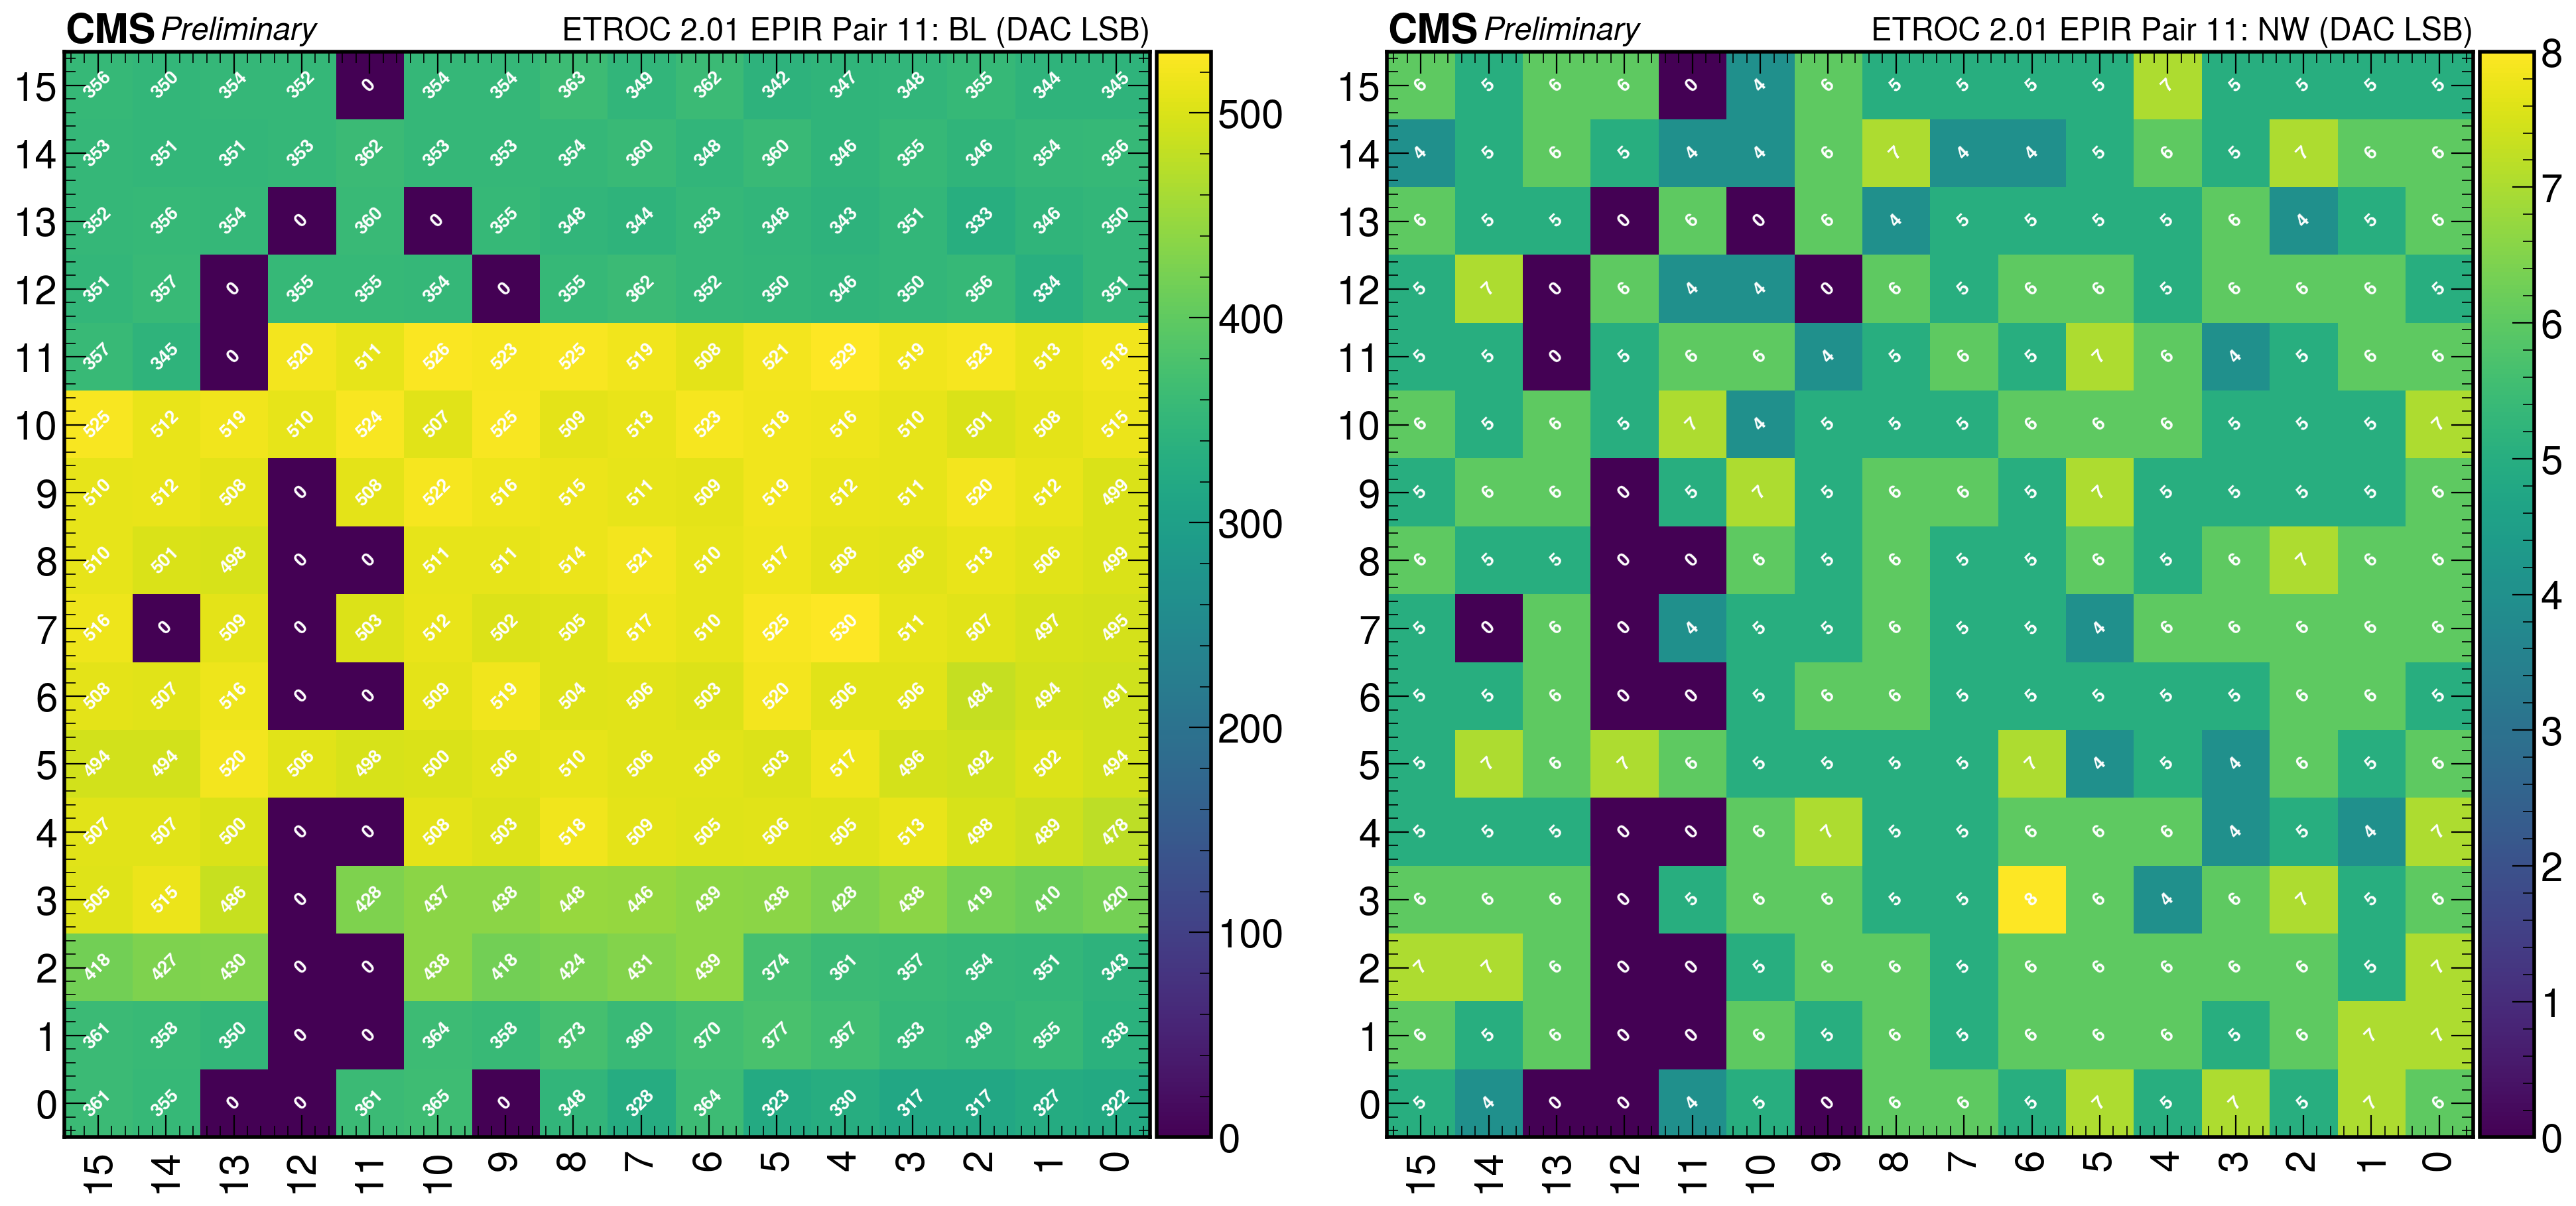

In [49]:
make_baselines(do_config=False)

In [ ]:
def do_pixel_operations(scan_list,board_offsets=None, noisy_pixels=None, power_mode='high'):
    i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn=False,Bypass_THCal=True,specified_addresses=chip_addresses[:], power_mode=power_mode)

    # offset = 0x0f
    # for chip_address in chip_addresses[:]:
    #     chip = i2c_conn.get_chip_i2c_connection(chip_address)
    #     row_indexer_handle,_,_ = chip.get_indexer("row")
    #     column_indexer_handle,_,_ = chip.get_indexer("column")
    #     for row, col in scan_list:
    #         print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
    #         column_indexer_handle.set(col)
    #         row_indexer_handle.set(row)
    #         i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    #     del chip, row_indexer_handle, column_indexer_handle

    if board_offsets is not None:
        time.sleep(5)

        for chip_address in chip_addresses[:]:
            if chip_address not in board_offsets:
                continue

            chip = i2c_conn.get_chip_i2c_connection(chip_address)
            row_indexer_handle,_,_ = chip.get_indexer("row")
            column_indexer_handle,_,_ = chip.get_indexer("column")
            for row, col in scan_list:
                print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col}) Setting Offset to {board_offsets[chip_address]}")
                column_indexer_handle.set(col)
                row_indexer_handle.set(row)
                # i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
                i2c_conn.pixel_decoded_register_write("TH_offset", format(board_offsets[chip_address], '06b'), chip)
            del chip, row_indexer_handle, column_indexer_handle

    if noisy_pixels is not None:
        time.sleep(5)

        for chip_address in chip_addresses:
            if chip_address not in noisy_pixels:
                continue
            chip = i2c_conn.get_chip_i2c_connection(chip_address)
            row_indexer_handle,_,_ = chip.get_indexer("row")
            column_indexer_handle,_,_ = chip.get_indexer("column")
            for row, col in noisy_pixels[chip_address]:
                print(f"Masking from trigger of chip {hex(chip_address)} Pixel ({row},{col})")
                column_indexer_handle.set(col)
                row_indexer_handle.set(row)

                i2c_conn.pixel_decoded_register_write("disTrigPath", "1", chip)
                #i2c_conn.pixel_decoded_register_write("DAC", format(1023, '010b'), chip)
                #i2c_conn.pixel_decoded_register_write("Bypass_THCal", "1", chip)

    time.sleep(5)

In [11]:
readout_board_names = chip_names[0]
self_trigger_delay = 484
info = f"offset_{offset}" # additional info for the output name
LED_pages = ["0x0000"] # LED pages to cycle through
active_channels = "0x0001"
polarity = "0x0027" # or "0x0023"
hostname = "192.168.2.3"

In [14]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

Reset Global Readout done for chip: 0x60
asyAlignFastcommand action done for chip: 0x60


In [21]:
def run_daq(trigger_board, trigger_board_name, run_number, total_time, daq_time, run_options="--start_DAQ_pulse --stop_DAQ_pulse"):
    trigger_bit_delay = int(trigger_board+'11'+format(self_trigger_delay, '010b'), base=2)
    trigger_bit_delay = 0x1800

    process_time = daq_time + 5
    iterations = ceil(total_time/process_time)
    LED_id = 0

    for it in range(iterations):
        LED_page = LED_pages[LED_id]
        LED_id += 1
        if LED_id >= len(LED_pages): LED_id = 0
        reset_string = ""
        if(it==0): reset_string = "--check_valid_data_start --clear_fifo"
        parser = parser_arguments.create_parser()
        (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {process_time} --run_name Run_{run_number} -o loop_{it} -v -w -s {LED_page} -p {polarity} -d {trigger_bit_delay} -a {active_channels} {run_options} {reset_string}".split())
        IPC_queue = multiprocessing.Queue()
        process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Run_{run_number}_loop_{it}'))
        process.start()

        IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
        while not IPC_queue.empty():
            pass
        time.sleep(daq_time)
        IPC_queue.put('stop DAQ')
        IPC_queue.put('memoFC Triggerbit')
        while not IPC_queue.empty():
            pass
        IPC_queue.put('allow threads to exit')
        process.join()

        del IPC_queue, process, parser

In [26]:
run_number = "testQInj_allPixel_15"
board_offsets = {
    0x60: 0x0a,
}
noisy_pixels = {
    0x60: [ # (row, col)
        #(10, 8),
        #(13, 4),
    ],
}
trigger_board = '0001'
trigger_board_name = chip_names[0]
power_mode = 'high'
total_time = 15
daq_time = 15

# make_baselines()
# do_pixel_operations(board_offsets=board_offsets, noisy_pixels=noisy_pixels, power_mode=power_mode)
print(f"Run {run_number} started at:", datetime.datetime.now().isoformat(sep=" "))
run_daq(trigger_board=trigger_board, trigger_board_name=trigger_board_name, run_number=run_number, total_time=total_time, daq_time=daq_time)

Run testQInj_allPixel_15 started at: 2024-02-02 17:21:49.166278
